In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot       as plt
from scipy.stats import chisquare
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
#from sklearn.metrics import roc_curv
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

Our main objective is to be able to classify the readmission or not of patients with diabetes in the study period. For this purpose, we make first a brief descriptive analysis of the data and then a Logit model is applied to make the classification as well as a random forest.

In [3]:
df= pd.read_csv('diabetic_data.csv',sep=";",na_values="?")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        99493 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      3197 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  61510 non-null object
medical_specialty           51817 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 non

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


**Exploratory Data Analysis**

Most patients were not readmitted, followed by those who were readmitted in more than 30 days and finally in less than 30 days.

Text(0.5, 1.0, 'Readmission')

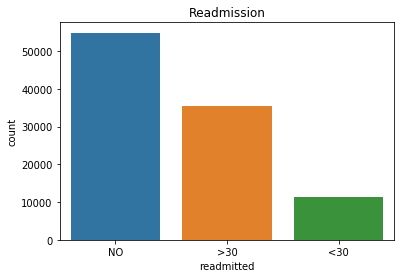

In [5]:
sns.countplot(x='readmitted', data = df)
plt.title("Readmission")

We begin to a descriptive analysis of the data, having in account that the variable "readmitted", for that we make a chi square test to evaluate if there is a relationship between "readmitted" and race, for example.

**Race**

In [6]:
data_crosstab = pd.crosstab(df['race'], 
                            df['readmitted'],  
                               margins = False) 
print(data_crosstab) 

readmitted        <30    >30     NO
race                               
AfricanAmerican  2155   6634  10421
Asian              65    161    415
Caucasian        8592  27124  40383
Hispanic          212    642   1183
Other             145    446    915


In [7]:
chisquare(data_crosstab)

Power_divergenceResult(statistic=array([ 23989.332438  ,  76450.47036307, 110026.10529475]), pvalue=array([0., 0., 0.]))

The p-value is zero, so we can say that there is independence between race and readmission with a 95% of confidence

**Gender**

In [8]:
data_crosstab2 = pd.crosstab(df['gender'], 
                            df['readmitted'],  
                               margins = False) 
print(data_crosstab2) 

readmitted        <30    >30     NO
gender                             
Female           6152  19518  29038
Male             5205  16027  25823
Unknown/Invalid     0      0      3


In [39]:
chisquare(data_crosstab2)

Power_divergenceResult(statistic=array([ 5796.94796161, 18286.79516106, 27705.59656605]), pvalue=array([0., 0., 0.]))

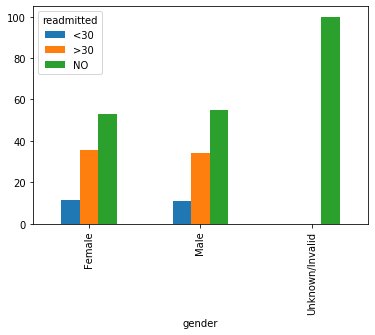

In [40]:
plot = pd.crosstab(index=df['gender'],
            columns=df['readmitted']).apply(lambda r: r/r.sum() *100,
                                              axis=1).plot(kind='bar')


The p-value is zero too, so we can say that there is independence between gender and readmission with a 95% of confidence, these variable should be included in the analyis

**Age**

In [41]:
data_crosstab3 = pd.crosstab(df['age'], 
                            df['readmitted'],  
                               margins = False) 
print(data_crosstab3) 
chisquare(data_crosstab3)

readmitted   <30   >30     NO
age                          
[0-10)         3    26    132
[10-20)       40   224    427
[20-30)      236   510    911
[30-40)      424  1187   2164
[40-50)     1027  3278   5380
[50-60)     1668  5917   9671
[60-70)     2502  7897  12084
[70-80)     3069  9475  13524
[80-90)     2078  6223   8896
[90-100)     310   808   1675


Power_divergenceResult(statistic=array([ 9922.37219336, 31691.71993248, 43388.27544474]), pvalue=array([0., 0., 0.]))

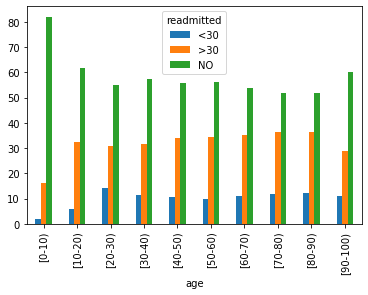

In [42]:
plot = pd.crosstab(index=df['age'],
            columns=df['readmitted']).apply(lambda r: r/r.sum() *100,
                                              axis=1).plot(kind='bar')


The p-value is zero too, so we can say that there is independence between gender and readmission with a 95% of confidence, these variable should be included in the analyis

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


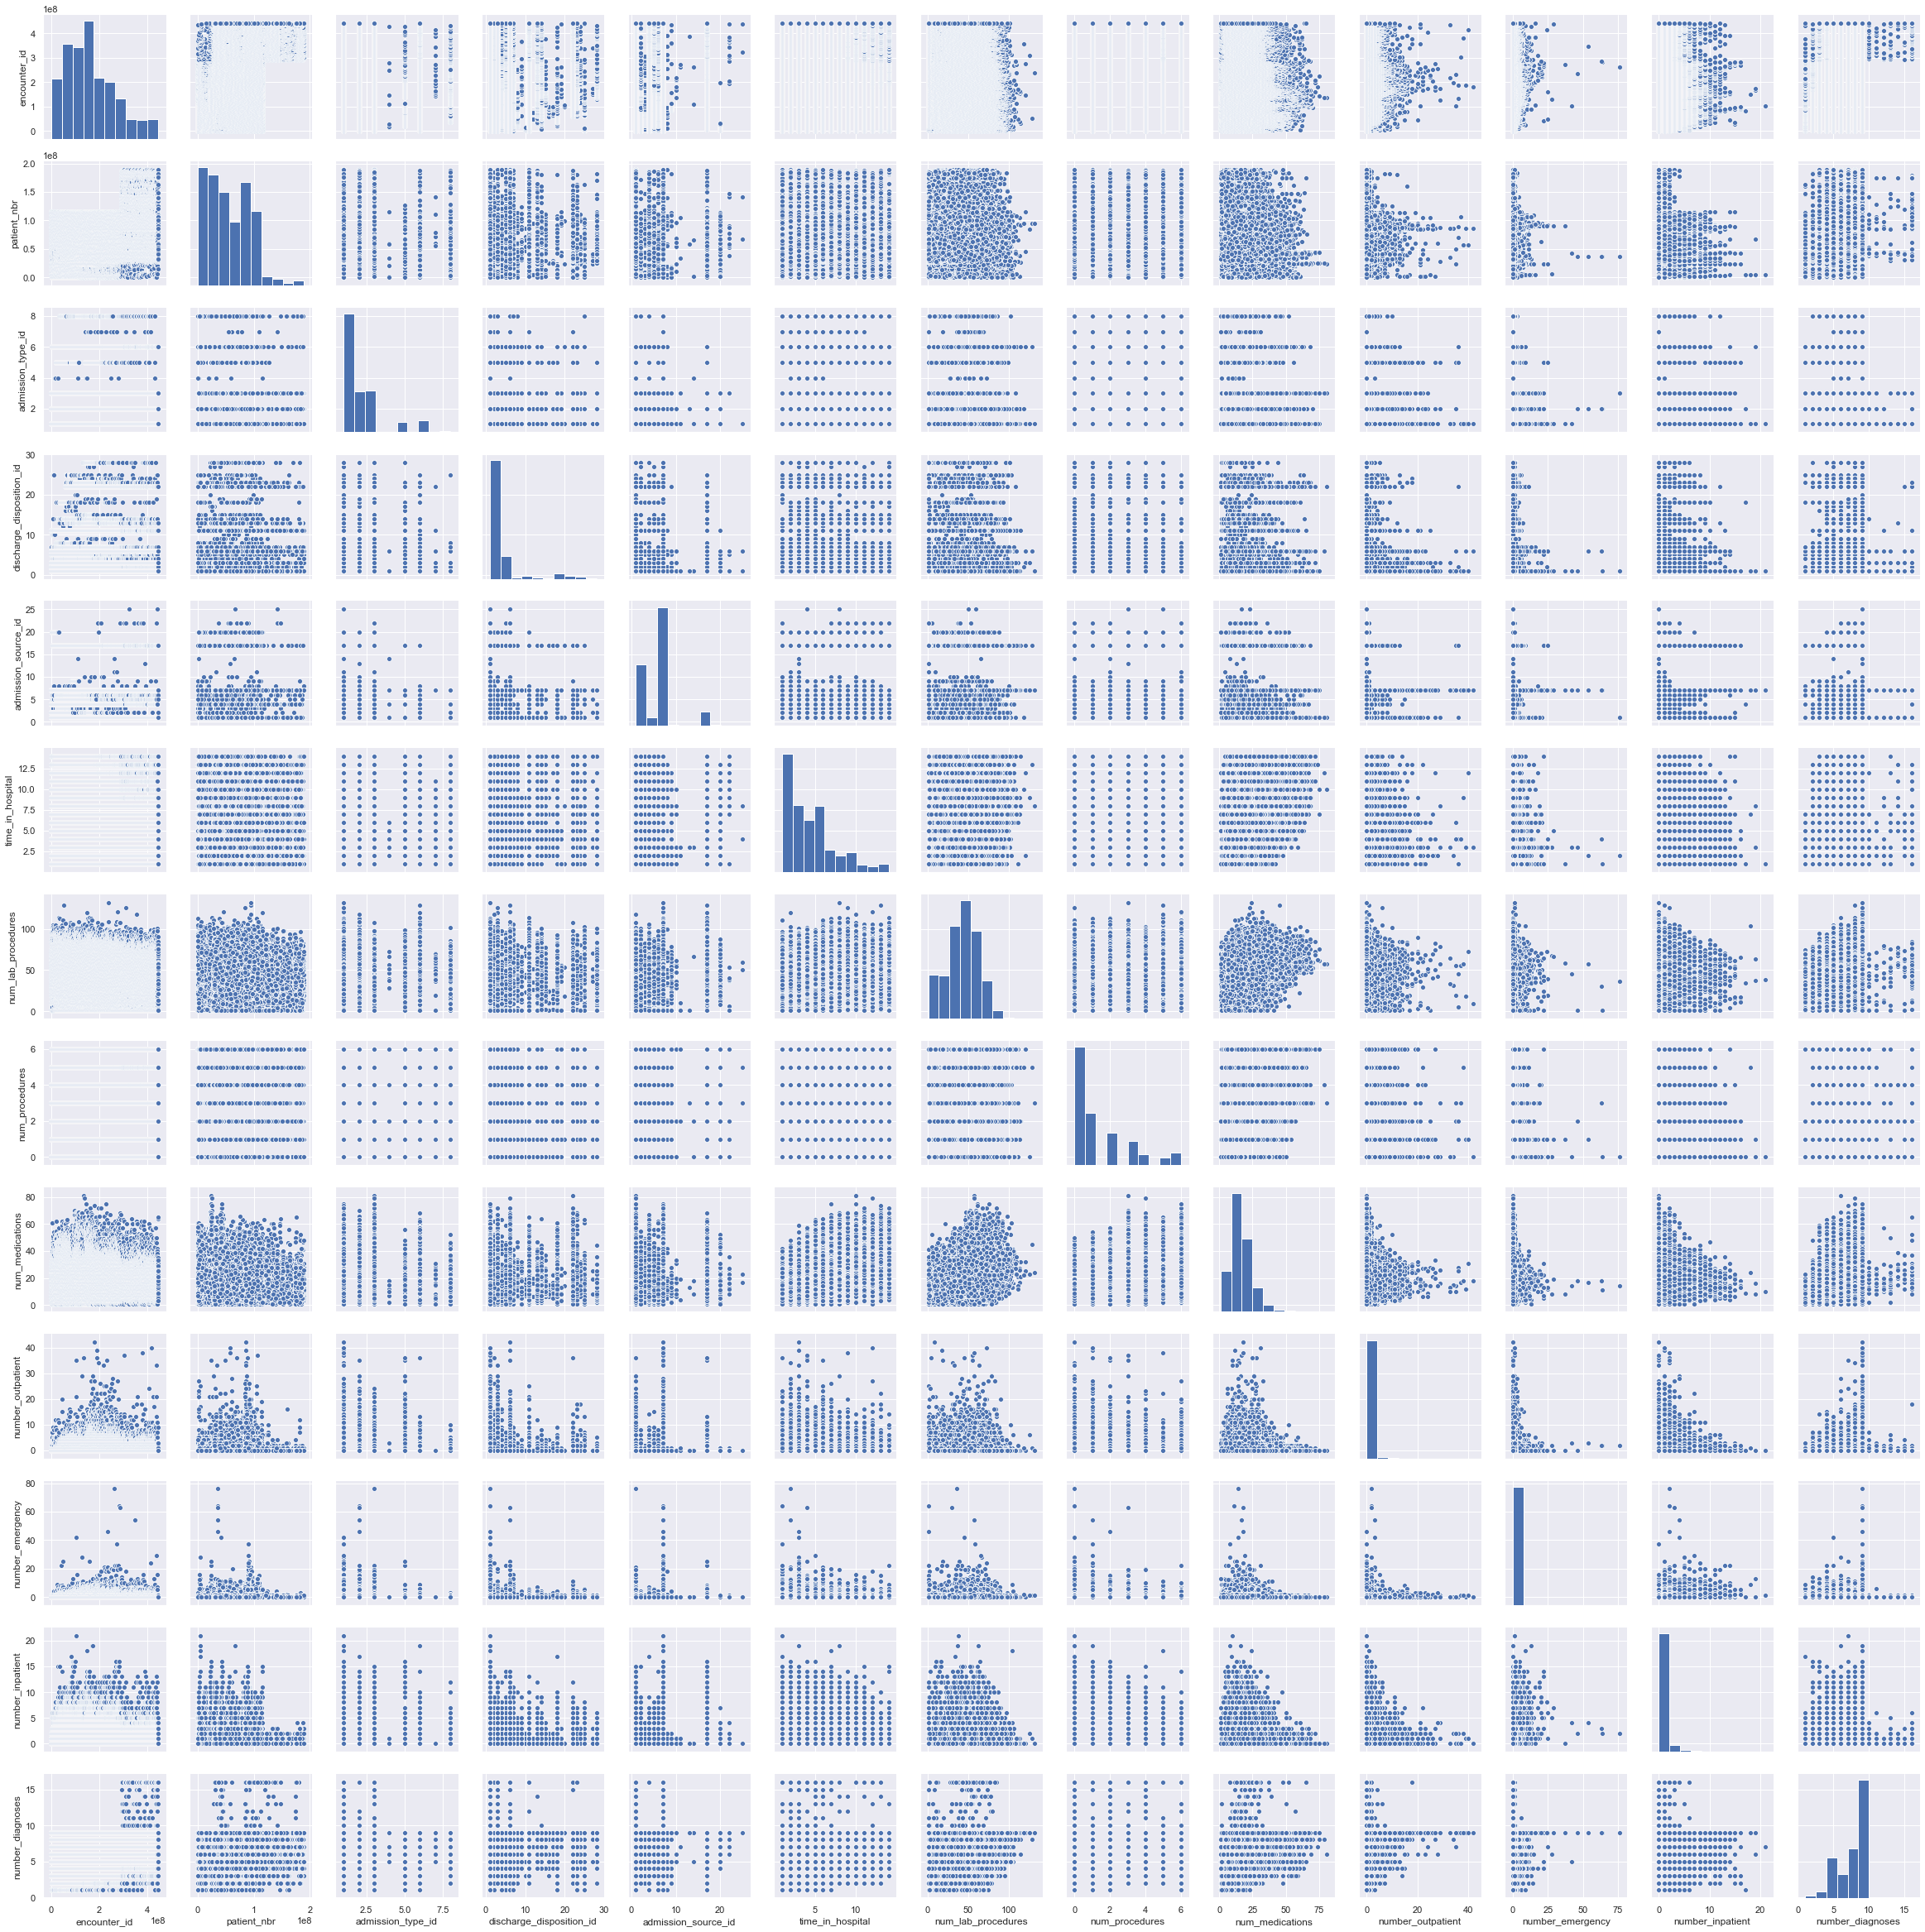

In [4]:
sns.set()
sns.pairplot(df, size = 2.5)
plt.show();

We make now the analysis of missing values before of start the analysis.

In [10]:
df2 = df.copy() 
df2.isnull().sum() 


encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

We eliminate the variables with most missing values:

In [11]:
df2= df2.drop(['weight','payer_code','medical_specialty'],axis=1)


In order to make the analysis we convert the variable readmission in two categories, if the patient was readmitted or not (in less than 30 days or more)

In [12]:
df2['readm'] = np.where(df2['readmitted'] == 'NO', 0, 1)
df2['readm']

0         0
1         1
2         0
3         0
4         0
         ..
101761    1
101762    0
101763    0
101764    0
101765    0
Name: readm, Length: 101766, dtype: int32

In [13]:
df2.groupby('readm').size()


readm
0    54864
1    46902
dtype: int64

Now we eliminate those patients who died.

In [14]:
df2 = df2[((df2.discharge_disposition_id != 11) &(df2.discharge_disposition_id != 13)& (df2.discharge_disposition_id != 14)&(df2.discharge_disposition_id != 19) & (df2.discharge_disposition_id != 20) &(df2.discharge_disposition_id != 21))]

In [15]:
df2.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readm
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,NO,0
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,Up,No,No,No,No,No,Ch,Yes,>30,1
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,Yes,NO,0
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,Up,No,No,No,No,No,Ch,Yes,NO,0
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,Steady,No,No,No,No,No,Ch,Yes,NO,0


In [16]:
numcolumn = df2.select_dtypes(include = [np.number]).columns
objcolumn = df2.select_dtypes(include = ['object']).columns


Now, we impute the missing values:

In [17]:
df2[numcolumn] = df2[numcolumn].fillna(0)
df2[objcolumn] = df2[objcolumn].fillna("unknown")

In [18]:
def map_now():
    listname = [('infections', 139),
                ('neoplasms', (239 - 139)),
                ('endocrine', (279 - 239)),
                ('blood', (289 - 279)),
                ('mental', (319 - 289)),
                ('nervous', (359 - 319)),
                ('sense', (389 - 359)),
                ('circulatory', (459-389)),
                ('respiratory', (519-459)),
                ('digestive', (579 - 519)),
                ('genitourinary', (629 - 579)),
                ('pregnancy', (679 - 629)),
                ('skin', (709 - 679)),
                ('musculoskeletal', (739 - 709)),
                ('congenital', (759 - 739)),
                ('perinatal', (779 - 759)),
                ('ill-defined', (799 - 779)),
                ('injury', (999 - 799))]
    
    
    dictcout = {}
    count = 1
    for name, num in listname:
        for i in range(num):
            dictcout.update({str(count): name})  
            count += 1
    return dictcout
  

def codemap(df, codes):
    import pandas as pd
    namecol = df.columns.tolist()
    for col in namecol:
        temp = [] 
        for num in df[col]:           
            if ((num is None) | (num in ['unknown', '?']) | (pd.isnull(num))): temp.append('unknown')
            elif(num.upper()[0] == 'V'): temp.append('supplemental')
            elif(num.upper()[0] == 'E'): temp.append('injury')
            else: 
                lkup = num.split('.')[0]
                temp.append(codes[lkup])           
        df.loc[:, col] = temp               
    return df 


listcol = ['diag_1', 'diag_2', 'diag_3']
codes = map_now()
df2[listcol] = codemap(df2[listcol], codes)

C:\Users\ecm2998j\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [19]:
df2 = df2.drop(['encounter_id', "patient_nbr", 'admission_type_id','readmitted'], axis =1)


We normalize all the numerical variables.

In [20]:
listnormal = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                     'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

from sklearn.preprocessing import StandardScaler

normal = StandardScaler()

df2[listnormal] = normal.fit_transform(df2[listnormal])

df2.describe()

,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readm
count,99343.000000,99343.000000,9.934300e+04,9.934300e+04,9.934300e+04,9.934300e+04,9.934300e+04,9.934300e+04,9.934300e+04,9.934300e+04,99343.000000
mean,3.517882,5.731083,1.874346e-14,-3.424256e-15,3.449070e-15,-1.776343e-15,1.182191e-13,6.322393e-14,-1.499301e-15,-9.426101e-14,0.471256
std,5.184359,4.065029,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,0.499176
min,1.000000,1.000000,-1.138438e+00,-2.137026e+00,-7.835647e-01,-1.850439e+00,-2.918627e-01,-2.116216e-01,-5.005746e-01,-3.298145e+00,0.000000
25%,1.000000,1.000000,-8.015554e-01,-6.071886e-01,-7.835647e-01,-7.386238e-01,-2.918627e-01,-2.116216e-01,-5.005746e-01,-7.221572e-01,0.000000
50%,1.000000,7.000000,-1.277904e-01,5.574070e-02,-1.962887e-01,-1.209485e-01,-2.918627e-01,-2.116216e-01,-5.005746e-01,3.082380e-01,0.000000
75%,3.000000,7.000000,5.459746e-01,7.186700e-01,3.909872e-01,4.967267e-01,-2.918627e-01,-2.116216e-01,2.928105e-01,8.234355e-01,1.000000
max,28.000000,25.000000,3.241035e+00,4.543262e+00,2.740091e+00,8.032365e+00,3.290615e+01,8.083523e+01,1.616051e+01,4.429819e+00,1.000000


In [7]:
df2.head()

,Unnamed: 0,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readm
0,0,Caucasian,Female,[0-10),25,1,-1.138438,-0.097243,-0.783565,-1.850439,...,No,No,No,No,No,No,No,No,No,0
1,1,Caucasian,Female,[10-20),1,7,-0.464673,0.820659,-0.783565,0.249657,...,No,Up,No,No,No,No,No,Ch,Yes,1
2,2,AfricanAmerican,Female,[20-30),1,7,-0.801555,-1.627080,2.152815,-0.368019,...,No,No,No,No,No,No,No,No,Yes,0
3,3,Caucasian,Male,[30-40),1,7,-0.801555,0.055741,-0.196289,0.002587,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,4,Caucasian,Male,[40-50),1,7,-1.138438,0.412703,-0.783565,-0.985694,...,No,Steady,No,No,No,No,No,Ch,Yes,0


**Logit model**

In [7]:
Y = df2['readm']
X = df2.drop(['readm'], axis =1)
X = pd.get_dummies(X,drop_first = True)
X

,Unnamed: 0,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_Steady,metformin-pioglitazone_Steady,change_No,diabetesMed_Yes
0,0,25,1,-1.138438,-0.097243,-0.783565,-1.850439,-0.291863,-0.211622,-0.500575,...,0,1,0,0,0,0,0,0,1,0
1,1,1,7,-0.464673,0.820659,-0.783565,0.249657,-0.291863,-0.211622,-0.500575,...,1,1,0,0,0,0,0,0,0,1
2,2,1,7,-0.801555,-1.627080,2.152815,-0.368019,1.288995,-0.211622,0.292810,...,0,1,0,0,0,0,0,0,1,1
3,3,1,7,-0.801555,0.055741,-0.196289,0.002587,-0.291863,-0.211622,-0.500575,...,1,1,0,0,0,0,0,0,0,1
4,4,1,7,-1.138438,0.412703,-0.783565,-0.985694,-0.291863,-0.211622,-0.500575,...,0,1,0,0,0,0,0,0,0,1
5,5,1,2,-0.464673,-0.607189,2.740091,0.002587,-0.291863,-0.211622,-0.500575,...,0,1,0,0,0,0,0,0,1,1
6,6,1,2,-0.127790,1.381599,-0.196289,0.620262,-0.291863,-0.211622,-0.500575,...,0,1,0,0,0,0,0,0,0,1
7,7,1,7,0.209092,1.534583,-0.783565,-0.491554,-0.291863,-0.211622,-0.500575,...,0,1,0,0,0,0,0,0,1,1
8,8,1,4,2.904152,1.279610,0.390987,1.485007,-0.291863,-0.211622,-0.500575,...,0,1,0,0,0,0,0,0,0,1
9,9,3,4,2.567270,-0.505200,0.978263,0.249657,-0.291863,-0.211622,-0.500575,...,0,1,0,0,0,0,0,0,0,1


In [6]:
#df2.to_csv(r'df2.csv')
df2= pd.read_csv('df2.csv',sep=",")


In [8]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size = .33, 
                                               random_state = 48)

In [9]:
print("shape of Xtrain,Xtest:",Xtrain.shape,Xtest.shape)
        

shape of Xtrain,Xtest: (66559, 137) (32784, 137)


In [10]:
from sklearn.linear_model import LogisticRegression
logisticreg = LogisticRegression(tol=1e-7, penalty='l2', C=0.0005)
logisticreg.fit(Xtrain, Ytrain)
Ylog = logisticreg.predict(Xtest)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [11]:
print(" The accuracy of the Logistic regression model:" ,logisticreg.score(Xtest, Ytest))


 The accuracy of the Logistic regression model: 0.6226817959980478


The accuracy of the model is 0,62. Which is a good accuracy.

In [8]:
logit_model=sm.MNLogit(Ytrain,sm.add_constant(Xtrain))
logit_model
result=logit_model.fit()
stats1=result.summary()
stats2=result.summary2()
print(stats1)
print(stats2)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


         Current function value: 0.642452
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:4112: RuntimeWarning: invalid value encountered in sqrt
  bse = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


                          MNLogit Regression Results                          
Dep. Variable:                  readm   No. Observations:                66559
Model:                        MNLogit   Df Residuals:                    66422
Method:                           MLE   Df Model:                          136
Date:                Tue, 29 Sep 2020   Pseudo R-squ.:                 0.07133
Time:                        14:04:11   Log-Likelihood:                -42761.
converged:                      False   LL-Null:                       -46046.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        readm=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               8.9820        nan        nan        nan         nan         nan
Unnamed: 0                      -5.333e-06   3.21e-07    -16.616    

For those people who have been readmitted we find, that the longer we stay in the hospital the more likely it is that the patient will be readmitted.  Other factors that also increase the probability of readmission are

Number of laboratory procedures
Number of medications
Number of emergencies
Being Caucasian
To be between 60 and 90 years old.



In [9]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Ytest, Ylog))

[[13564  3957]
 [ 8413  6850]]


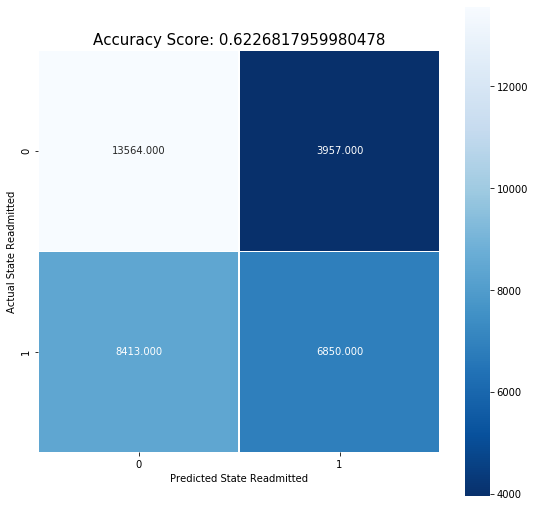

In [10]:
plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix(Ytest, Ylog), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual State Readmitted');
plt.xlabel('Predicted State Readmitted');
all_sample_title = 'Accuracy Score: {0}'.format(logisticreg.score(Xtest, Ytest))
plt.title(all_sample_title, size = 15);

Although the R2 of the model is low we have that the model has a good accuracy

**Random Forest**

In [12]:
random_forest = RandomForestClassifier(random_state=42,n_estimators=500)
random_forest.fit(Xtrain, Ytrain)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [13]:
Yrandforest = random_forest.predict(Xtest)

In [14]:
scorey =random_forest.predict_proba(Xtest)[:,1]
#rfpr, rtpr, thresholds = roc_curve(Ytest, scorey)
print(" Accuracy of Randomeforest classification: ", random_forest.score(Xtest, Ytest))


 Accuracy of Randomeforest classification:  0.6450402635431918


The accuracy of the random forest model is similar: 0,64

In [15]:
print(confusion_matrix(Ytest, Yrandforest))


[[12470  5051]
 [ 6586  8677]]


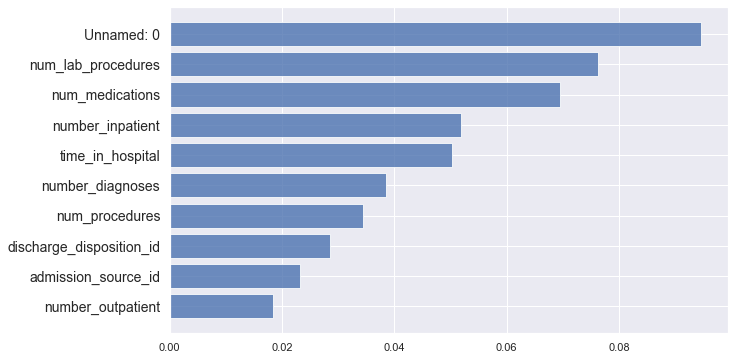

In [16]:
feature_names = Xtrain.columns
feature_imports = random_forest.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.show()

In [17]:
estimator = random_forest.estimators_[5]
estimator

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1201263687, splitter='best')

In [18]:

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                rounded = True, proportion = False, 
                precision = 2, filled = True)



In [18]:
#from subprocess import call
from sklearn.tree import pygraphviz 
graph.draw('tree.dot')

#(graph,) = pydot.graph_from_dot_file('somefile.dot')
#graph.write_png('somefile.png')

ImportError: cannot import name 'pygraphviz' from 'sklearn.tree' (C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\__init__.py)